MCG-NJU/videomae-base-finetuned-kinetics and MCG-NJU/videomae-base <br>
https://huggingface.co/MCG-NJU/videomae-base <br>
https://huggingface.co/docs/transformers/model_doc/videomae#videomae

# Import Library

In [1]:
!pip uninstall -y tensorflow

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0


In [2]:
import torch
torch.autograd.set_detect_anomaly(True)

print('pytorch version', torch.__version__)
print("GPU available:", torch.cuda.device_count())
#print('GPU name:',torch.cuda.get_device_name(0))

# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pytorch version 2.5.1+cu124
GPU available: 1


In [3]:
#!nvcc --version

In [4]:
# For data augmentation
from torchvision import transforms

In [5]:
#!pip install -q transformers==4.35.0

In [6]:
import transformers

# For Tokenizers
from transformers import VideoMAEImageProcessor, VideoMAEConfig

# For Model
from transformers import VideoMAEModel, VideoMAEForVideoClassification

# For TPU
from transformers import set_seed
from torch.optim import AdamW

In [7]:
!pip install -q datasets #==2.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.7 MB/s eta 0:00:00


In [8]:
# For Data Loaders
import datasets
from torch.utils.data import Dataset, DataLoader
#from torchvision.transforms import Compose, Resize, ToTensor

In [9]:
#!pip install -q accelerate==0.21.0

In [10]:
# For Display
from tqdm.notebook import tqdm

# For GPU
from accelerate import Accelerator, notebook_launcher

In [11]:
!pip install -q decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 90.9 MB/s eta 0:00:00


In [12]:
# Use PyTorch bridge for Decord
import decord

from decord.bridge import set_bridge
decord.bridge.set_bridge("torch")

from decord import VideoReader

In [13]:
#!pip install -q av

In [14]:
#import kagglehub
import random

import cv2
from google.colab.patches import cv2_imshow

import os
import PIL
import gc
from glob import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,5]

In [15]:
import torch.nn.functional as F
from torch.nn import Linear, Softmax, CrossEntropyLoss, ReLU

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialse Globle Variables

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
from google.colab import userdata
secret_token_hf = userdata.get('HF_TOKEN')

In [19]:
gdrive_path = '/content/drive/MyDrive/Kaggle/SignLanguage'
local_path = '/content/SignLanguage'

In [20]:
BATCH_SIZE = 2
print('BATCH_SIZE =',BATCH_SIZE)

BUFFER_SIZE = BATCH_SIZE * 8
print('BUFFER_SIZE =',BUFFER_SIZE)

MODEL_TRANSFORMER = 'MCG-NJU/videomae-base-short' #'MCG-NJU/videomae-base-finetuned-kinetics' #'MCG-NJU/videomae-base'

FRAME_STEPS = 4
print('FRAME_STEPS =',FRAME_STEPS)

CLIP_LENGTH = 32 # MTech project was with CLIP_LENGTH = 85, CLIP_LENGTH of model = 32
print('CLIP_LENGTH =',CLIP_LENGTH)


CLIP_HEIGHT = 640
CLIP_WIDTH = 480
print('Image Dimension =', CLIP_WIDTH,'X', CLIP_HEIGHT)

CLIP_SIZE = 224
print('Image Dimension =', CLIP_SIZE,'X', CLIP_SIZE)

BATCH_SIZE = 2
BUFFER_SIZE = 16
FRAME_STEPS = 4
CLIP_LENGTH = 32
Image Dimension = 480 X 640
Image Dimension = 224 X 224


In [21]:
#import os
#os.environ["CUDA_MODULE_LOADING"] = "LAZY"

In [22]:
def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [23]:
seed_everything(42)

# Import Data

In [24]:
data_dir = f'{gdrive_path}/ProcessedData_vivit'
print(data_dir)

/content/drive/MyDrive/Kaggle/SignLanguage/ProcessedData_vivit


In [25]:
# Copy videos from Google Drive to local disk for faster loading during training
if not os.path.exists(local_path):
    shutil.copytree(data_dir, local_path)

print("Videos copied to local disk.")

Videos copied to local disk.


In [26]:
print(local_path)

/content/SignLanguage


In [27]:
classes = sorted(os.listdir(local_path))
print(classes)

['bad', 'beautiful', 'big', 'blind', 'cheap', 'cold', 'curved', 'deaf', 'dry', 'expensive', 'famous', 'fast', 'female', 'flat', 'good', 'happy', 'healthy', 'hot', 'light', 'long', 'loose', 'loud', 'narrow', 'new', 'old', 'quiet', 'sad', 'short', 'sick', 'slow', 'small', 'tall', 'ugly', 'warm', 'wet', 'wide', 'young']


In [28]:
label_to_idx = {}
idx_to_label = {}

for idx, label in enumerate(classes):
  class_folder = os.path.join(local_path, label)
  if os.path.exists(data_dir):
    label_to_idx[label] = idx
    idx_to_label[idx] = label

In [29]:
print(label_to_idx)

{'bad': 0, 'beautiful': 1, 'big': 2, 'blind': 3, 'cheap': 4, 'cold': 5, 'curved': 6, 'deaf': 7, 'dry': 8, 'expensive': 9, 'famous': 10, 'fast': 11, 'female': 12, 'flat': 13, 'good': 14, 'happy': 15, 'healthy': 16, 'hot': 17, 'light': 18, 'long': 19, 'loose': 20, 'loud': 21, 'narrow': 22, 'new': 23, 'old': 24, 'quiet': 25, 'sad': 26, 'short': 27, 'sick': 28, 'slow': 29, 'small': 30, 'tall': 31, 'ugly': 32, 'warm': 33, 'wet': 34, 'wide': 35, 'young': 36}


In [30]:
print(idx_to_label)

{0: 'bad', 1: 'beautiful', 2: 'big', 3: 'blind', 4: 'cheap', 5: 'cold', 6: 'curved', 7: 'deaf', 8: 'dry', 9: 'expensive', 10: 'famous', 11: 'fast', 12: 'female', 13: 'flat', 14: 'good', 15: 'happy', 16: 'healthy', 17: 'hot', 18: 'light', 19: 'long', 20: 'loose', 21: 'loud', 22: 'narrow', 23: 'new', 24: 'old', 25: 'quiet', 26: 'sad', 27: 'short', 28: 'sick', 29: 'slow', 30: 'small', 31: 'tall', 32: 'ugly', 33: 'warm', 34: 'wet', 35: 'wide', 36: 'young'}


In [31]:
# Collect all video files
video_path = []
labels_int = []
labels_text = []
for idx, label in enumerate(classes):
  class_folder = os.path.join(local_path, label)
  #print(class_folder)
  video_file = glob(os.path.join(class_folder, '*.MOV'))
  #print(video_file)
  video_path.extend(video_file)
  labels_int.extend([idx] * len(video_file))
  labels_text.extend([label] * len(video_file))

In [32]:
print('input path size:', len(video_path))
print(video_path)

input path size: 610
['/content/SignLanguage/bad/MVI_9513.MOV', '/content/SignLanguage/bad/MVI_9514.MOV', '/content/SignLanguage/bad/MVI_9352.MOV', '/content/SignLanguage/bad/MVI_9516.MOV', '/content/SignLanguage/bad/MVI_9354.MOV', '/content/SignLanguage/bad/MVI_9271.MOV', '/content/SignLanguage/bad/MVI_5161.MOV', '/content/SignLanguage/bad/MVI_9272.MOV', '/content/SignLanguage/bad/MVI_9433.MOV', '/content/SignLanguage/bad/MVI_5242.MOV', '/content/SignLanguage/bad/MVI_5321.MOV', '/content/SignLanguage/bad/MVI_5241.MOV', '/content/SignLanguage/bad/MVI_5320.MOV', '/content/SignLanguage/bad/MVI_9434.MOV', '/content/SignLanguage/bad/MVI_5319.MOV', '/content/SignLanguage/bad/MVI_9273.MOV', '/content/SignLanguage/bad/MVI_5243.MOV', '/content/SignLanguage/bad/MVI_9353.MOV', '/content/SignLanguage/bad/MVI_5162.MOV', '/content/SignLanguage/bad/MVI_5163.MOV', '/content/SignLanguage/bad/MVI_9435.MOV', '/content/SignLanguage/beautiful/MVI_9725.MOV', '/content/SignLanguage/beautiful/MVI_9570.MOV', 

In [33]:
print('labels size:', len(labels_int))
print(labels_int)

labels size: 610
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19

In [34]:
print('labels size:', len(labels_text))
print(labels_text)

labels size: 610
['bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'blind', 'blind', 'blind', 'blind', 'blind', 'blind', 'blind', 'blind', 'cheap', 'cheap', 'cheap', 'cheap', 'cheap', 'cheap', 'cheap', 'cheap', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'curved', 'curved', 'curved', 'curved', 'curved', 'curved', 'curved', 'curved', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry

# Train Test Split

In [35]:
train_path, val_path, train_label, val_label = train_test_split(video_path, labels_int, test_size=0.2, stratify=labels_text, random_state=42)
train_path, test_path, train_label, test_label = train_test_split(train_path, train_label, test_size=0.2, stratify=train_label, random_state=42)

In [36]:
print('Train data size:',len(train_path))
print('Val data size:',len(val_path))
print('Test data size:',len(test_path))

Train data size: 390
Val data size: 122
Test data size: 98


In [37]:
train_label[:5]

[8, 30, 24, 27, 17]

# Validating the input data - NOT USED

In [ ]:
#idx = 2
#train_path[idx]

In [ ]:
#vr_demo = VideoReader(train_path[idx])#, width=CLIP_WIDTH, height=CLIP_HEIGHT)

In [ ]:
#print('Number of Fames in the video:',len(vr_demo))

In [ ]:
#frame = vr_demo[1]
#print('Shape of the frame:',frame.shape)

In [ ]:
#key_indices = vr_demo.get_key_indices()
#key_frames = vr_demo.get_batch(key_indices)
#print(key_frames.shape)

In [ ]:
#print(key_frames.permute(0, 3, 1, 2).shape)

In [ ]:
#image_processor_demo = VivitImageProcessor.from_pretrained(MODEL_TRANSFORMER,
#                                                           size={'width':CLIP_WIDTH, 'height':CLIP_HEIGHT},
#                                                           crop_size={'width':CLIP_WIDTH, 'height':CLIP_HEIGHT}
#                                                           )

In [ ]:
#model_inputs_demo = image_processor_demo.preprocess(videos=list(key_frames),
#                                               return_tensors='pt',
#                                               input_data_format='channels_last', # image in (height, width, num_channels) format.
#                                               )

In [ ]:
#print(model_inputs_demo.pixel_values.shape)

In [ ]:
#reshaped_video = model_inputs_demo.pixel_values[0].permute(0, 2, 3, 1)

In [ ]:
#plt.imshow(reshaped_video[0])

In [ ]:
#sample_input = model_inputs_demo.pixel_values[0]
#
## Define original dimensions
#height =  sample_input.shape[2]
#width = sample_input.shape[3]
#
## Define the crop factor
#target_height = height - (height // 10) # Crop 10% of the height
#target_width =  width - (width // 2) # Crop 50% of width
#
## Define (Offset) the amount of crop required at each side of the image
#offset_height = (height - target_height) // 2
#offset_width = (width - target_width) // 2

In [ ]:
#sample_out = transforms.v2.functional.crop(sample_input, offset_height, offset_width, target_height, target_width)

In [ ]:
#print(sample_input.shape)
#print(sample_out.shape)

In [ ]:
#reshaped_video = sample_out.permute(0, 2, 3, 1)

In [ ]:
#plt.imshow(reshaped_video[0])

In [ ]:
## Define a sample transformation pipeline
#transform_demo = transforms.Compose([
#    #transforms.RandomHorizontalFlip(),
#    #transforms.RandomVerticalFlip(),
#    #transforms.RandomResizedCrop(size=(640, 480), scale=(0.5, 1)),  # Zoom and crop # (1080, 1920)
#    transforms.v2.Resize((224, 224)),
#    transforms.v2.RandomPerspective(),
#    #transforms.v2.ColorJitter(brightness=(0.2, 0.8), contrast=(0.2, 0.8), saturation=(0.2, 0.8), hue=(-0.2, 0.2)),
#    transforms.v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
#    #transforms.v2.ColorJitter(),
#    #transforms.v2.RandomRotation(15),
#    #transforms.v2.ToImage(),
#    transforms.v2.ToDtype(torch.float32, scale=True)
#])

In [ ]:
#selected_video = sample_out
#print(len(selected_video))
#print(selected_video.shape)

In [ ]:
#augmented_video = transform_demo(selected_video)

In [ ]:
#print(augmented_video.shape)

In [ ]:
#plt.imshow(augmented_video[4].permute(1, 2, 0))

In [ ]:
#print(augmented_video.max())
#print(augmented_video.min())

In [ ]:
#plt.imshow(key_frames[0])

# Create Dataset

In [110]:
hyperparameters = {
    "learning_rate": 0.01,
    "num_epochs": 1000, # set to very high number
    "seed": 42,
    "patience": 10, # early stopping
    "output_dir_pt": f"{gdrive_path}/videoMAE_pytorch_GPU_3.pt",
    'dropout_rate': 0.1,
    'num_hidden_layers':2,
    'intermediate_size': 512,
    'num_attention_heads': 2, #originally 12
    'attention_type': 'joint_space_time',
    'hidden_size': 768//12
}

In [39]:
image_processor = VideoMAEImageProcessor.from_pretrained(MODEL_TRANSFORMER)

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

In [106]:
model_config = VideoMAEConfig.from_pretrained(MODEL_TRANSFORMER, id2label=idx_to_label,label2id=label_to_idx,
                                                    num_labels=len(classes), num_frames=CLIP_LENGTH,
                                                    architectures='VideoMAEForVideoClassification',
                                                    hidden_dropout_prob=hyperparameters['dropout_rate'],
                                                    attention_probs_dropout_prob=hyperparameters['dropout_rate'],
                                                    use_mean_pooling=True,
                                                    hidden_size=hyperparameters['hidden_size'],
                                                    #hidden_dropout_prob=hyperparameters['dropout_rate'],
                                                    #attention_probs_dropout_prob=hyperparameters['dropout_rate'],
                                                    num_hidden_layers=hyperparameters['num_hidden_layers'],
                                                    intermediate_size=hyperparameters['intermediate_size'],
                                                    num_attention_heads=hyperparameters['num_attention_heads'],
                                                    #attention_type=hyperparameters['attention_type'],
                                                    return_dict=True)
model_transformer = VideoMAEForVideoClassification.from_pretrained(MODEL_TRANSFORMER, attn_implementation="sdpa", config=model_config, ignore_mismatched_sizes=True) # attn_implementation="sdpa"

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--MCG-NJU--videomae-base-short/snapshots/9fa00797f9e861e08e49069f5039d60e02b37122/config.json
Model config VideoMAEConfig {
  "architectures": "VideoMAEForVideoClassification",
  "attention_probs_dropout_prob": 0.1,
  "decoder_hidden_size": 384,
  "decoder_intermediate_size": 1536,
  "decoder_num_attention_heads": 6,
  "decoder_num_hidden_layers": 4,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 64,
  "id2label": {
    "0": "bad",
    "1": "beautiful",
    "2": "big",
    "3": "blind",
    "4": "cheap",
    "5": "cold",
    "6": "curved",
    "7": "deaf",
    "8": "dry",
    "9": "expensive",
    "10": "famous",
    "11": "fast",
    "12": "female",
    "13": "flat",
    "14": "good",
    "15": "happy",
    "16": "healthy",
    "17": "hot",
    "18": "light",
    "19": "long",
    "20": "loose",
    "21": "loud",
    "22": "narrow",
    "23": "new",
    "24": "old",
    "25"

In [41]:
#num_patches_per_frame = (model_transformer.config.image_size // model_transformer.config.patch_size) ** 2
#seq_length = (model_transformer.config.num_frames // model_transformer.config.tubelet_size) * num_patches_per_frame
##bool_masked_pos = torch.randint(0, 2, (BATCH_SIZE, model_transformer.config.num_hidden_layers, model_transformer.config.num_attention_heads, seq_length, seq_length)).bool()
#bool_masked_pos = torch.randint(0, 2, (BATCH_SIZE, seq_length)).bool()

In [ ]:
model_transformer.config

In [42]:
class CustomDataset(Dataset):
    def __init__(self, pixel_values, labels): #head_masks
        self.labels = labels.to('cpu')
        #self.head_masks = head_masks.to('cpu')
        self.pixel_values = pixel_values.to('cpu')

    def __len__(self):
        return len(self.pixel_values)

    def __getitem__(self, idx):
        item = {
            'pixel_values': self.pixel_values[idx],
            #'head_mask': self.head_masks[idx],
            'labels': self.labels[idx]
        }
        return item

In [45]:
#print(model_transformer.config.num_hidden_layers)
#print(model_transformer.config.num_attention_heads)

In [46]:
#((224)**2)

In [43]:
class CreateDataset():
    def __init__(self, clip_length, image_processor, model_transformer, class_len):
        super().__init__()
        self.clip_length = clip_length
        self.image_processor = image_processor
        self.class_len = class_len
        self.model_transformer = model_transformer

        self.clip_size = self.model_transformer.config.image_size
        self.num_layers = self.model_transformer.config.num_hidden_layers
        self.att_heads = self.model_transformer.config.num_attention_heads
        self.patch_size = self.model_transformer.config.patch_size

        # Define a transformation pipeline
        self.transform_train = transforms.v2.Compose([
                                    transforms.v2.ToImage(),
                                    transforms.v2.RandomPerspective(),
                                    transforms.v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.05),
                                    transforms.v2.ToDtype(torch.uint8, scale=False)
                                ])

    def create_dataset(self, video_paths, labels, training=True):
        # Creating Pixel Values
        pixel_values = []
        for path in tqdm(video_paths):
            # Read and process Videos
            vr = VideoReader(path)
            video = vr.get_batch(list(range(len(vr))))
            video = video[:self.clip_length]

            if training:
                # Data Preperation for ML model with Augmentation
                video = self.transform_train(video.permute(0, 3, 1, 2))
            else:
                # Data Preperation for ML Model without Augmentation
                video = transforms.v2.functional.to_dtype(video.permute(0, 3, 1, 2), torch.uint8, scale=False)

            # Scaling the video to ML model's desired format
            video = self.image_processor(list(video), return_tensors='pt', input_data_format='channels_first')

            pixel_values.append(video['pixel_values'].squeeze(0))

            # Force garbage collection
            del vr, video
            gc.collect()

        pixel_values = torch.stack(pixel_values)
        #labels = torch.tensor(labels, dtype=torch.uint8)

        # Creating Attention Mask
        #head_masks = []
        #for label in labels:
        #    #head_mask = torch.ones(self.clip_length, 3, self.clip_size, self.clip_size) # head_mask: Shape [batch_size, num_layers, num_heads]
        #    #head_mask[:, :, :self.clip_size // 2, :self.clip_size // 2] = 0 # mask half of the heads in layer 0
        #    # Compute seq_length
        #    seq_length = 3136 #(self.clip_size // self.patch_size) ** 2 + 1
        #    head_mask = torch.randint(0, 2, (self.att_heads, seq_length, seq_length), dtype=torch.float32) #self.num_layers,
        #
        #    # head_mask: Shape [clip_length, channels, clip_size, clip_size]
        #    #head_mask = torch.randint(0, 2, (self.clip_length, 3,  self.clip_size, self.clip_size), dtype=torch.float32)
        #    head_masks.append(head_mask)
        #
        #head_masks = torch.stack(head_masks)

        # Labels
        labels = F.one_hot(torch.Tensor(labels).long(), num_classes=self.class_len).type(torch.DoubleTensor)
        labels = labels.clone().detach()

        return CustomDataset(pixel_values=pixel_values,
                             #head_masks=head_masks,
                             labels=labels)

In [44]:
dataset_obj = CreateDataset(CLIP_LENGTH, image_processor, model_transformer, len(classes))

# Testing the custome image processing class

In [ ]:
train_ds = dataset_obj.create_dataset(train_path[:2], train_label[:2], training=True)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
del train_ds
torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/2 [00:00<?, ?it/s]

0

In [ ]:
inputs = next(iter(train_dl))
print(inputs['pixel_values'].shape, inputs['head_mask'].shape, inputs['labels'].shape)

torch.Size([2, 32, 3, 224, 224]) torch.Size([2, 32, 3, 224, 224]) torch.Size([2, 37])


In [ ]:
#mask = torch.randint(0, 2, (2, 32, 3, 225, 225), dtype=torch.float32)
# Now `mask` is a random binary mask of shape [batch_size, frame_length, channels, height, width]
#print(mask.shape)

In [ ]:
#mask[0]

In [ ]:
#inputs['head_mask'][0]

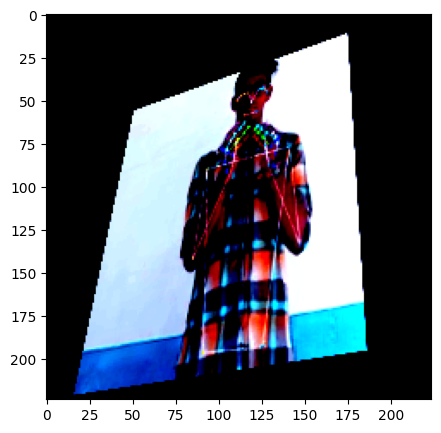

In [ ]:
plt.imshow(inputs['pixel_values'][0,21].cpu().permute(1, 2, 0))

In [ ]:
print(inputs['pixel_values'].min())
print(inputs['pixel_values'].max())

tensor(-1.8606)
tensor(2.6400)


In [ ]:
val_ds = dataset_obj.create_dataset(val_path[:2], val_label[:2], training=False)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
del val_ds
torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/2 [00:00<?, ?it/s]

0

In [ ]:
# Example usage
inputs = next(iter(val_dl))
print(inputs['pixel_values'].shape, inputs['head_mask'].shape, inputs['labels'].shape)

torch.Size([2, 32, 3, 224, 224]) torch.Size([2, 12]) torch.Size([2, 37])


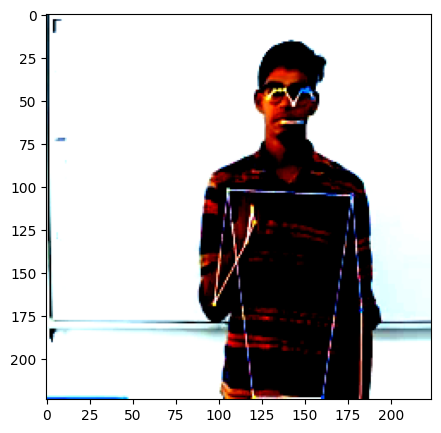

In [ ]:
plt.imshow(inputs['pixel_values'][0,7].cpu().permute(1, 2, 0))

In [ ]:
print(inputs['pixel_values'].min())
print(inputs['pixel_values'].max())

tensor(-2.1179)
tensor(2.6400)


# Creating DataLoader

In [ ]:
#torch.cuda.empty_cache()

In [45]:
train_ds = dataset_obj.create_dataset(train_path, train_label, training=True)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
del train_ds
torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/390 [00:00<?, ?it/s]

0

In [46]:
inputs = next(iter(train_dl))
print(inputs['pixel_values'].shape, inputs['labels'].shape) #inputs['head_mask'].shape

torch.Size([2, 32, 3, 224, 224]) torch.Size([2, 37])


In [47]:
val_ds = dataset_obj.create_dataset(val_path, val_label, training=False)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
del val_ds
torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/122 [00:00<?, ?it/s]

17

In [48]:
inputs = next(iter(val_dl))
print(inputs['pixel_values'].shape, inputs['labels'].shape) #inputs['head_mask'].shape

torch.Size([2, 32, 3, 224, 224]) torch.Size([2, 37])


In [ ]:
#inputs['labels'].type()

In [ ]:
#train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
#val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

# Model Training

In [ ]:
#config_demo = VideoMAEConfig.from_pretrained(MODEL_TRANSFORMER, id2label=idx_to_label,label2id=label_to_idx, num_labels=len(classes),
#                                             num_frames=CLIP_LENGTH,
#                                             architectures='VideoMAEForVideoClassification',return_dict=True)
#demo_transformer = VideoMAEForVideoClassification.from_pretrained(MODEL_TRANSFORMER, config=config_demo)

In [ ]:
#demo_transformer.config

In [ ]:
#demo_transformer

In [ ]:
#output = demo_transformer(**inputs)

In [ ]:
#output.logits.argmax(1)

tensor([29, 29])

In [ ]:
# Creating NN Layer
#class SignClassificationModel(torch.nn.Module):
#    def __init__(self, model_name, idx_to_label, label_to_idx, classes_len):
#        super(SignClassificationModel, self).__init__()
#        self.config = VideoMAEConfig.from_pretrained(model_name, id2label=idx_to_label,
#                                                     label2id=label_to_idx, hidden_dropout_prob=hyperparameters['dropout_rate'],
#                                                     attention_probs_dropout_prob=hyperparameters['dropout_rate'],
#                                                     num_frames=CLIP_LENGTH,
#                                                     #num_attention_heads=hyperparameters['num_att_heads'],
#                                                     return_dict=True)
#        self.backbone = VideoMAEForVideoClassification.from_pretrained(model_name, config=self.config)  # Load ViT model
#        #self.ff_head = Linear(3137*self.backbone.config.hidden_size, 1)
#        self.ff_head = Linear(self.backbone.config.hidden_size, classes_len)
#        #self.class_head = Linear(1, classes_len) # Convert to classes feature vector
#        #self.relu = ReLU()
#        self.softmax = Softmax(dim=1)
#
#    def forward(self, images):
#        x = self.backbone(images).last_hidden_state #[:, 0]  # Extract embeddings
#        self.backbone.gradient_checkpointing_enable()
#        # Freeze the backbone
#        for param in self.backbone.parameters():
#          param.requires_grad = False
#
#        #x = torch.flatten(x, start_dim=1) # Newly added
#        # Reduce along emb_dimension1 (axis 1)
#        reduced_tensor = x.mean(dim=1)
#        reduced_tensor = self.ff_head(reduced_tensor)
#        #x = self.relu(x)
#        #x = self.class_head(x)  # Convert to number of classes
#        #x = self.softmax(x) # Find Softmax
#        #x = F.softmax(x, dim=1, dtype=torch.float32)
#        return reduced_tensor

In [58]:
#num_patches_per_frame = (model_transformer.config.image_size // model_transformer.config.patch_size) ** 2
#seq_length = (model_transformer.config.num_frames // model_transformer.config.tubelet_size) * num_patches_per_frame
##bool_masked_pos = torch.randint(0, 2, (BATCH_SIZE, model_transformer.config.num_hidden_layers, model_transformer.config.num_attention_heads, seq_length, seq_length)).bool()
#bool_masked_pos = torch.randint(0, 2, (BATCH_SIZE, seq_length)).bool()

In [53]:
#acclerated_bool_masked_pos = bool_masked_pos.to(device)

In [57]:
#del bool_masked_pos

In [52]:
#bool_masked_pos

In [111]:
torch.cuda.empty_cache()

In [112]:
# Initialize TensorBoard writer
#writer = SummaryWriter(log_dir='runs/experiment_1')  # Path to where logs will be saved

# Now we train the model
def training_function(model_transformer):
    # Initialize accelerator
    accelerator = Accelerator()#(fp16=True)

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # Loss function
    criterion = CrossEntropyLoss()

    # Instantiate optimizer
    optimizer = AdamW(model_transformer.parameters(), lr=hyperparameters["learning_rate"])

    # Define the learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True, min_lr=0.00001
    )

    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the prepare method.
    accelerated_model, acclerated_criterion, acclerated_optimizer, acclerated_train_dl, acclerated_val_dl = accelerator.prepare(model_transformer, criterion, optimizer, train_dl, val_dl)

    # Build the training loop
    epochs_no_improve = 0
    min_val_loss = float("inf")

    for epoch in range(hyperparameters["num_epochs"]):
      # We only enable the progress bar on the main process to avoid having 8 progress bars.
      progress_bar = tqdm(range(len(acclerated_train_dl)), disable=not accelerator.is_main_process)
      progress_bar.set_description(f"Epoch: {epoch}")
      accelerated_model.train()
      training_loss = []
      for batch in acclerated_train_dl:
          # Forward pass
          #train_pixel_values = batch['pixel_values']
          #train_labels = batch['labels']
          #train_output = accelerated_model(pixel_values=batch['pixel_values'], labels=batch['labels'], head_mask=acclerated_bool_masked_pos)
          train_output = accelerated_model(**batch)
          train_logits = train_output.logits
          #train_softmax = torch.nn.functional.softmax(train_logits, dim=-1)
          #train_preds = train_logits.argmax(-1)

          #train_loss = train_output.loss
          train_labels = batch['labels']
          train_loss = acclerated_criterion(train_logits, train_labels)
          #train_loss = torch.nn.functional.cross_entropy(input=train_preds, target=train_labels)

          # Backward pass
          accelerator.backward(train_loss)

          # Optimize
          acclerated_optimizer.step()
          acclerated_optimizer.zero_grad()

          # We gather the loss from the GPU cores to have them all.
          training_loss.append(accelerator.gather(train_loss[None]))
          progress_bar.set_postfix({'loss': train_loss.item()})
          progress_bar.update(1)

      # Compute average training loss
      training_loss_final = torch.stack(training_loss).sum().item() / len(training_loss)
      # Use accelerator.print to print only on the main process.
      accelerator.print(f"epoch {epoch}: learning rate:", scheduler.get_last_lr())
      accelerator.print(f"epoch {epoch}: training loss:", training_loss_final)

      # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
      accelerated_model.eval()
      validation_loss = []

      for batch in acclerated_val_dl:
          with torch.no_grad():
              #val_output = accelerated_model(pixel_values=batch['pixel_values'], labels=batch['labels'], head_mask=acclerated_bool_masked_pos)
              val_output = accelerated_model(**batch)

          val_logits = val_output.logits
          #val_softmax = torch.nn.functional.softmax(val_logits, dim=-1)
          #val_preds = val_logits.argmax(-1)

          #val_loss = val_output.loss
          val_labels = batch['labels']
          val_loss = acclerated_criterion(val_logits, val_labels)
          #val_loss = torch.nn.functional.cross_entropy(input=val_preds, target=val_labels)

          # We gather the loss from the GPU cores to have them all.
          validation_loss.append(accelerator.gather(val_loss[None]))

      # Compute average validation loss
      validation_loss_final = torch.stack(validation_loss).sum().item() / len(validation_loss)
      # Use accelerator.print to print only on the main process.
      accelerator.print(f"epoch {epoch}: validation loss:", validation_loss_final)

      # Step the scheduler
      scheduler.step(validation_loss_final)

      # Save model with early stopping
      if validation_loss_final < min_val_loss:
          epochs_no_improve = 0
          min_val_loss = validation_loss_final
          # Save the entire model (including architecture and weights)
          torch.save(accelerated_model, hyperparameters['output_dir_pt'])
          accelerator.print("Saveing the model")
          #accelerated_model.save_pretrained(hyperparameters['output_dir_transformer'])
          continue
      else:
        epochs_no_improve += 1
        # Check early stopping condition
        if epochs_no_improve == hyperparameters["patience"]:
          accelerator.print("Early stopping!")
          break

In [113]:
# Run the trainer function
training_function(model_transformer)

  0%|          | 0/195 [00:00<?, ?it/s]

epoch 0: learning rate: [0.01]
epoch 0: training loss: 3.8038464375031302
epoch 0: validation loss: 3.605300277960105
Saveing the model


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 1: learning rate: [0.01]
epoch 1: training loss: 3.57400367749043
epoch 1: validation loss: 3.594200288663145
Saveing the model


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 2: learning rate: [0.01]
epoch 2: training loss: 3.553291508478996
epoch 2: validation loss: 3.6380604134231316


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 3: learning rate: [0.01]
epoch 3: training loss: 3.5531256198883057
epoch 3: validation loss: 3.570191017916945
Saveing the model


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 4: learning rate: [0.01]
epoch 4: training loss: 3.5442626152283108
epoch 4: validation loss: 3.5781267979105964


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 5: learning rate: [0.01]
epoch 5: training loss: 3.540360341927944
epoch 5: validation loss: 3.6280412478525133


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 6: learning rate: [0.01]
epoch 6: training loss: 3.545276790398818
epoch 6: validation loss: 3.62250617879336


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 7: learning rate: [0.005]
epoch 7: training loss: 3.4777034258231136
epoch 7: validation loss: 3.6337484179950152


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 8: learning rate: [0.005]
epoch 8: training loss: 3.4766031393638026
epoch 8: validation loss: 3.543753336687557
Saveing the model


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 9: learning rate: [0.005]
epoch 9: training loss: 3.454399832089742
epoch 9: validation loss: 3.4441097447129545
Saveing the model


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 10: learning rate: [0.005]
epoch 10: training loss: 3.426935891004709
epoch 10: validation loss: 3.5790415748220976


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 11: learning rate: [0.005]
epoch 11: training loss: 3.43171783104921
epoch 11: validation loss: 3.6701097605658357


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 12: learning rate: [0.005]
epoch 12: training loss: 3.4082986880571413
epoch 12: validation loss: 3.4548203222087173


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 13: learning rate: [0.0025]
epoch 13: training loss: 3.3347880204518634
epoch 13: validation loss: 3.4810442592276902


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 14: learning rate: [0.0025]
epoch 14: training loss: 3.2801185424511248
epoch 14: validation loss: 3.374149820843681
Saveing the model


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 15: learning rate: [0.0025]
epoch 15: training loss: 3.26147661117407
epoch 15: validation loss: 3.3170112684124806
Saveing the model


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 16: learning rate: [0.0025]
epoch 16: training loss: 3.1946712888204134
epoch 16: validation loss: 3.2269342756662214
Saveing the model


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 17: learning rate: [0.0025]
epoch 17: training loss: 3.205301847519019
epoch 17: validation loss: 3.219910191707924
Saveing the model


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 18: learning rate: [0.0025]
epoch 18: training loss: 3.1512949558404775
epoch 18: validation loss: 3.2843163502020913


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 19: learning rate: [0.0025]
epoch 19: training loss: 3.1454528701611055
epoch 19: validation loss: 3.2216993199020134


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 20: learning rate: [0.0025]
epoch 20: training loss: 3.1091341067583134
epoch 20: validation loss: 3.283823916169464


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 21: learning rate: [0.00125]
epoch 21: training loss: 3.0480549494425455
epoch 21: validation loss: 3.206225308238483
Saveing the model


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 22: learning rate: [0.00125]
epoch 22: training loss: 3.0331513395676244
epoch 22: validation loss: 3.178770056513489
Saveing the model


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 23: learning rate: [0.00125]
epoch 23: training loss: 2.9947189052899676
epoch 23: validation loss: 3.1752562464260663
Saveing the model


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 24: learning rate: [0.00125]
epoch 24: training loss: 2.9834646460337515
epoch 24: validation loss: 3.2094112888711397


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 25: learning rate: [0.00125]
epoch 25: training loss: 2.9763109711500313
epoch 25: validation loss: 3.192829285488754


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 26: learning rate: [0.00125]
epoch 26: training loss: 2.964071270441398
epoch 26: validation loss: 3.1991495988408074


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 27: learning rate: [0.000625]
epoch 27: training loss: 2.930279290676117
epoch 27: validation loss: 3.2130565789879344


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 28: learning rate: [0.000625]
epoch 28: training loss: 2.9154862052355055
epoch 28: validation loss: 3.2153622820729115


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 29: learning rate: [0.000625]
epoch 29: training loss: 2.9066195445182994
epoch 29: validation loss: 3.232407630467024


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 30: learning rate: [0.0003125]
epoch 30: training loss: 2.8757085894927
epoch 30: validation loss: 3.2143462710693234


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 31: learning rate: [0.0003125]
epoch 31: training loss: 2.8624629344695656
epoch 31: validation loss: 3.2163970919906117


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 32: learning rate: [0.0003125]
epoch 32: training loss: 2.861053762680445
epoch 32: validation loss: 3.217127393503658


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 33: learning rate: [0.00015625]
epoch 33: training loss: 2.842649840697264
epoch 33: validation loss: 3.217125383556866
Early stopping!


In [ ]:
'''
epoch 4: learning rate: [0.0001]
epoch 4: training loss: 0.6882950996685969
epoch 4: validation loss: 0.9578143467764473
Saveing the model
Epoch: 5: 100%
 95/95 [25:09<00:00,  3.08s/it, loss=0.214]
epoch 5: learning rate: [0.0001]
epoch 5: training loss: 0.334061036224624
epoch 5: validation loss: 0.6734721306142293
Saveing the model
Epoch: 6: 100%
 95/95 [19:56<00:00,  3.09s/it, loss=0.0452]
epoch 6: learning rate: [0.0001]
epoch 6: training loss: 0.1617632053964036
epoch 6: validation loss: 0.7600871691855394
Epoch: 7: 100%
 95/95 [14:43<00:00,  3.09s/it, loss=0.0333]
epoch 7: learning rate: [0.0001]
epoch 7: training loss: 0.11765114350955148
epoch 7: validation loss: 0.6403691204387643
Saveing the model
Epoch: 8: 100%
 95/95 [09:29<00:00,  3.09s/it, loss=0.0172]
epoch 8: learning rate: [0.0001]
epoch 8: training loss: 0.043264231083326436
epoch 8: validation loss: 0.5814998383316883
Saveing the model
Epoch: 9: 100%
 95/95 [04:53<00:00,  3.09s/it, loss=0.0133]
epoch 9: learning rate: [0.0001]
epoch 9: training loss: 0.023389429934813005
epoch 9: validation loss: 0.5116678952042194

'''

# Load model

In [ ]:
#model_pretrained = VivitForVideoClassification.from_pretrained(hyperparameters['output_dir_transformer']).to(device)
#model_pretrained.eval()
#print("Entire model loaded successfully!")

In [ ]:
#model_pretrained = torch.load(hyperparameters['output_dir'], map_location=torch.device('cpu'))
#model_pretrained.eval()
#print("Entire model loaded successfully!")

# Model Testing - TEST Data

In [70]:
class CustomDatasetTest(Dataset):
    def __init__(self, pixel_values, labels):
        self.pixel_values = pixel_values.to('cpu')
        self.labels = labels.to('cpu')

    def __len__(self):
        return len(self.pixel_values)

    def __getitem__(self, idx):
        item = {
            'pixel_values': self.pixel_values[idx],
            'labels':self.labels[idx]
        }
        return item

In [71]:
class CreateDatasetTest():
    def __init__(self, clip_length, image_processor, class_len):
        super().__init__()
        self.clip_length = clip_length
        self.image_processor = image_processor
        self.class_len = class_len

    def create_dataset(self, video_paths, labels):
        pixel_values = []

        for path in tqdm(video_paths):
            # Read and process Videos
            vr = VideoReader(path)
            video = vr.get_batch(list(range(len(vr))))
            video = video[:self.clip_length]

            # Data Preperation for ML Model without Augmentation
            video = transforms.v2.functional.to_dtype(video.permute(0, 3, 1, 2), torch.uint8, scale=False)
            video = self.image_processor(list(video), return_tensors='pt', input_data_format='channels_first')

            pixel_values.append(video['pixel_values'].squeeze(0))

            # Force garbage collection
            del vr, video
            gc.collect()

        pixel_values = torch.stack(pixel_values)
        labels = F.one_hot(torch.Tensor(labels).long(), num_classes=self.class_len).type(torch.DoubleTensor)
        labels = labels.clone().detach()

        return CustomDatasetTest(pixel_values=pixel_values,
                                 labels=labels)

In [72]:
dataset_test_obj = CreateDatasetTest(CLIP_LENGTH, image_processor, len(classes))

In [73]:
test_ds = dataset_test_obj.create_dataset(test_path, test_label)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)
del test_ds
gc.collect()

  0%|          | 0/98 [00:00<?, ?it/s]

17

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
hyperparameters = {
    "learning_rate": 0.0001,
    "num_epochs": 1000, # set to very high number
    "seed": 42,
    "patience": 10, # early stopping
    "output_dir_pt": f"{gdrive_path}/videoMAE_pytorch_GPU_3.pt",
    'dropout_rate': 0.3,
    'dropout_rate': 0.3,
    'num_hidden_layers':2,
    'intermediate_size': 512,
    'num_att_heads': 2, #originally 12
    'attention_type': 'joint_space_time'
}

In [74]:
# Now we train the model
def testing_function(model_pretrained):
    # Initialize accelerator
    accelerator = Accelerator()#(fp16=True)

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    accelerated_model, acclerated_test_dl = accelerator.prepare(model_pretrained, test_dl)


    # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
    accelerated_model.eval()

    test_labels = []
    test_preds = []

    for batch in tqdm(acclerated_test_dl):
        with torch.no_grad():
            outputs = accelerated_model(**batch)

        test_logits = outputs.logits
        test_softmax = torch.nn.functional.softmax(test_logits, dim=-1)
        test_pred = test_softmax.argmax(-1)
        test_preds.append(test_pred)

        test_label = batch['labels']
        test_labels.append(test_label)

        #test_preds = torch.cat(test_pred)
        #test_labels = torch.cat(test_label)
    return test_labels, test_preds


In [76]:
actual_label, predicted_test_label = testing_function(model_transformer)

  0%|          | 0/49 [00:00<?, ?it/s]

In [77]:
actual_labels = torch.cat(actual_label, 0).to('cpu')
predicted_test_labels = torch.cat(predicted_test_label,0).to('cpu')

In [78]:
predicted_test_labels.numpy()

array([14,  0, 24, 17, 25,  0, 22, 16,  1,  4, 16, 20, 31,  1,  0, 17, 34,
       36, 34, 33, 36,  4, 11,  5, 33, 29, 25, 21, 16,  0,  0, 18, 16, 11,
       33, 14,  4, 24,  0, 33, 14, 16,  7, 14, 14, 16, 11, 11, 30, 16,  0,
        2, 29, 36,  4, 33, 16, 15, 21, 17, 14, 16,  1, 33, 16, 17, 33, 16,
        5, 16, 24, 11, 11, 35, 33, 28, 16, 29, 14, 16, 14, 29,  0, 33, 21,
       17, 36, 17, 16,  0,  0,  6, 16,  0, 11, 11, 14, 11])

In [81]:
actual_labels.argmax(-1)

tensor([27, 29, 27, 31,  5, 25, 30, 14, 13, 26, 31, 18, 36,  7,  8, 29, 21, 15,
        33, 15, 22,  1, 35, 21, 25, 28,  2, 34, 11, 14, 28,  4, 14, 29, 28, 19,
         9, 23, 15, 24, 21, 22, 32,  2, 16, 24, 17,  8, 27, 21, 17, 35, 31, 15,
        10, 23, 36, 34, 30, 19, 17, 35,  3,  0, 27,  5, 28, 11, 19,  8, 23, 17,
        33, 25,  6, 16,  8, 11,  0,  2, 34, 24, 34, 36,  0, 30, 33, 14,  5, 33,
        23, 20, 30, 22,  2,  0, 16, 12])

In [93]:
target_names = list(model_transformer.config.label2id.keys())

In [99]:
conf_matrix = confusion_matrix(actual_labels.argmax(-1).numpy(), predicted_test_labels.numpy())

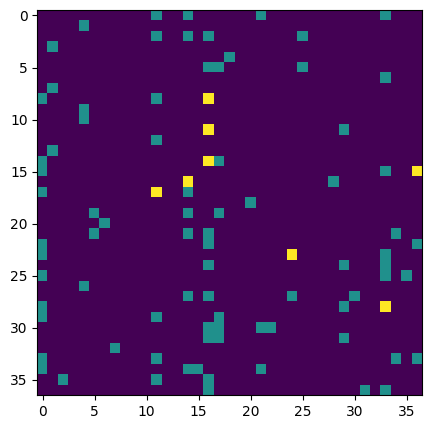

In [101]:
plt.imshow(conf_matrix)

In [96]:
print(classification_report(y_true=actual_labels.argmax(-1).numpy(),
                            y_pred=predicted_test_labels.numpy(),
                            target_names=target_names, zero_division='warn'
                            ))

              precision    recall  f1-score   support

         bad       0.00      0.00      0.00       4.0
   beautiful       0.00      0.00      0.00       1.0
         big       0.00      0.00      0.00       4.0
       blind       0.00      0.00      0.00       1.0
       cheap       0.00      0.00      0.00       1.0
        cold       0.00      0.00      0.00       3.0
      curved       0.00      0.00      0.00       1.0
        deaf       0.00      0.00      0.00       1.0
         dry       0.00      0.00      0.00       4.0
   expensive       0.00      0.00      0.00       1.0
      famous       0.00      0.00      0.00       1.0
        fast       0.00      0.00      0.00       3.0
      female       0.00      0.00      0.00       1.0
        flat       0.00      0.00      0.00       1.0
        good       0.00      0.00      0.00       4.0
       happy       0.00      0.00      0.00       4.0
     healthy       0.00      0.00      0.00       3.0
         hot       0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Create MP Objects

In [ ]:
hand_model_path = '/content/drive/MyDrive/Kaggle/SignLanguage/hand_landmarker.task'
pose_model_path = '/content/drive/MyDrive/Kaggle/SignLanguage/pose_landmarker.task'

In [ ]:
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
#FaceLandmarker = mp.tasks.vision.FaceLandmarker
#FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a hand landmarker instance with the video mode:
options_hand = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path = hand_model_path),
    running_mode=VisionRunningMode.VIDEO)

# Create a pose landmarker instance with the video mode:
options_pose = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=pose_model_path),
    running_mode=VisionRunningMode.VIDEO)

## Create a face landmarker instance with the video mode:
#options_face = FaceLandmarkerOptions(
#    base_options=BaseOptions(model_asset_path=face_model_path),
#    running_mode=VisionRunningMode.VIDEO)

#detector_face = vision.FaceLandmarker.create_from_options(options_face)
detector_hand = vision.HandLandmarker.create_from_options(options_hand)
detector_pose = vision.PoseLandmarker.create_from_options(options_pose)

In [ ]:
holistic = mp_holistic.Holistic(
    static_image_mode=False,
    model_complexity=1,
    smooth_landmarks=True,
    enable_segmentation=False,
    refine_face_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
    )

# Model testing - PROD Data

In [ ]:
class CustomDatasetProd(Dataset):
    def __init__(self, pixel_values):
        self.pixel_values = pixel_values.to('cpu')

    def __len__(self):
        return len(self.pixel_values)

    def __getitem__(self, idx):
        item = {
            'pixel_values': self.pixel_values[idx]
        }
        return item

In [ ]:
class CreateDatasetProd():
    def __init__(self
                , clip_len
                , clip_size
                , frame_step
                ):
        super().__init__()
        self.clip_len = clip_len
        self.clip_size = clip_size
        self.frame_step = frame_step

        # Define a sample transformation pipeline
        self.transform_prod = transforms.v2.Compose([
                                    transforms.v2.ToImage(),
                                    transforms.v2.Resize((self.clip_size, self.clip_size)),
                                    transforms.v2.ToDtype(torch.float32, scale=True)
                                ])

    def read_video(self, video_path):
        # Read the video and convert to frames
        vr = VideoReader(video_path)
        total_frames = len(vr)

        # Determine frame indices based on total frames
        if total_frames < self.clip_len:
            key_indices = list(range(total_frames))
            for _ in range(self.clip_len - len(key_indices)):
                key_indices.append(key_indices[-1])
        else:
            key_indices = list(range(0, total_frames, max(1, total_frames // self.clip_len)))[:self.clip_len]

        #load frames
        frames = vr.get_batch(key_indices)
        del vr
        # Force garbage collection
        gc.collect()

        return frames

    def add_landmarks(self, video):
        annotated_image = []
        for frame in video:

            #Convert pytorch Tensor to CV2 image
            image = frame.permute(1, 2, 0).numpy() # Convert to (H, W, C) format for mediapipe to work

            results = holistic.process(image)

            mp_drawing.draw_landmarks(
                image,
                results.left_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec = mp_drawing_styles.get_default_hand_landmarks_style(),
                connection_drawing_spec = mp_drawing_styles.get_default_hand_connections_style()
                )
            mp_drawing.draw_landmarks(
                image,
                results.right_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec = mp_drawing_styles.get_default_hand_landmarks_style(),
                connection_drawing_spec = mp_drawing_styles.get_default_hand_connections_style()
                )
            mp_drawing.draw_landmarks(
                image,
                results.pose_landmarks,
                mp_holistic.POSE_CONNECTIONS,
                landmark_drawing_spec = mp_drawing_styles.get_default_pose_landmarks_style(),
                #connection_drawing_spec = None
                )

            annotated_image.append(torch.from_numpy(image))

            del image, results
            # Force garbage collection
            gc.collect()

        return torch.stack(annotated_image)

    def create_dataset(self, video_paths):
        pixel_values = []
        for path in tqdm(video_paths):
            #print('Video', path)
            # Read and process Videos
            video = self.read_video(path)
            #print('Stage 1',video.shape)
            video = transforms.v2.functional.resize(video.permute(0, 3, 1, 2), size=(self.clip_size*2, self.clip_size*3)) # Auto converts to (F, C, H, W) format
            #print('Stage 2',video.shape)
            video = self.add_landmarks(video)
            #print('Stage 3',video.shape)
            # Data Preperation for ML Model without Augmentation
            video = self.transform_prod(video.permute(0, 3, 1, 2))

            #print('Stage 4',video.shape)
            pixel_values.append(video.to(device))
            del video
            # Force garbage collection
            gc.collect()

        pixel_values = torch.stack(pixel_values).to(device)
        return CustomDatasetProd(pixel_values=pixel_values)


In [ ]:
dataset_prod_obj = CreateDatasetProd(CLIP_LENGTH, CLIP_SIZE, FRAME_STEPS)

In [ ]:
prod_data_dir = f'{gdrive_path}/ProdData'
print(prod_data_dir)

/content/drive/MyDrive/Kaggle/SignLanguage/ProdData


In [ ]:
# Collect all video files
prod_video_path = []

prod_video_file = glob(os.path.join(prod_data_dir, '*.mov'))
print(prod_video_file)
prod_video_path.extend(prod_video_file)

['/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_2_tall.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_3_sad.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_1_ugly.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_4_short.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_5_tall.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_6_sad.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_7_quiet.mov']


In [ ]:
print('input path size:', len(prod_video_path))
print(prod_video_path)

input path size: 7
['/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_2_tall.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_3_sad.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_1_ugly.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_4_short.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_5_tall.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_6_sad.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_7_quiet.mov']


In [ ]:
prod_ds = dataset_prod_obj.create_dataset(prod_video_path)

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
prod_dl = DataLoader(prod_ds, batch_size=BATCH_SIZE)

In [ ]:
prod_inputs = next(iter(prod_dl))
print(prod_inputs['pixel_values'].shape) #prod_inputs['input_ids'].shape, prod_inputs['attention_mask'].shape, np.array(prod_inputs['labels']).shape

torch.Size([4, 32, 3, 224, 224])


In [ ]:
sample_video = prod_inputs['pixel_values'][0].permute(0, 2, 3, 1)
sample_video.shape

torch.Size([32, 224, 224, 3])

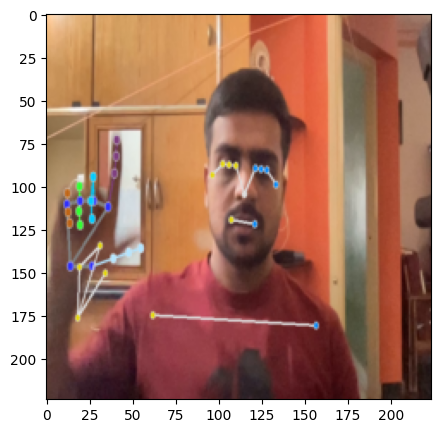

In [ ]:
plt.imshow(sample_video[15])

In [ ]:
# Now we train the model
def prod_function():
    # Initialize accelerator
    accelerator = Accelerator()#(fp16=True)

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # Load the model
    model_pretrained = VivitForVideoClassification.from_pretrained(hyperparameters['output_dir_transformer'])

    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    accelerated_model, acclerated_prod_dl = accelerator.prepare(model_pretrained, prod_dl)

    # Build the training loop
    epochs_no_improve = 0

    # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
    accelerated_model.eval()

    test_preds = []

    for batch in tqdm(acclerated_prod_dl):
        with torch.no_grad():
            outputs = accelerated_model(**batch)

        test_logits = outputs.logits
        test_softmax = torch.nn.functional.softmax(test_logits, dim=-1)
        test_pred = test_softmax.argmax(-1)
        test_preds.append(test_pred)

        #test_preds = torch.cat(test_pred)
        #test_labels = torch.cat(test_label)
    return test_preds


In [ ]:
predicted_label = prod_function()

loading configuration file /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_4/config.json
Model config VivitConfig {
  "_name_or_path": "google/vivit-b-16x2",
  "architectures": [
    "VivitForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu_fast",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "bad",
    "1": "beautiful",
    "2": "big",
    "3": "blind",
    "4": "cheap",
    "5": "cold",
    "6": "curved",
    "7": "deaf",
    "8": "dry",
    "9": "famous",
    "10": "fast",
    "11": "female",
    "12": "flat",
    "13": "good",
    "14": "happy",
    "15": "healthy",
    "16": "hot",
    "17": "light",
    "18": "long",
    "19": "loose",
    "20": "loud",
    "21": "narrow",
    "22": "new",
    "23": "old",
    "24": "quiet",
    "25": "sad",
    "26": "short",
    "27": "sick",
    "28": "slow",
    "29": "small",
    "30": "tall",
    "31": "warm",
    "32": "wet",
    "33": "wide",
   

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
predicted_label

[tensor([32,  8, 22, 26], device='cuda:0'),
 tensor([30, 18, 24], device='cuda:0')]

In [ ]:
predicted_prod_labels = torch.cat(predicted_label,0).to('cpu')

In [ ]:
for val in predicted_prod_labels:
  print(idx_to_label[val.item()])

wet
dry
new
short
tall
long
quiet


In [ ]:
for path in prod_video_path:
  print(os.path.basename(path).split('/')[-1])

prod_2_tall.mov
prod_3_sad.mov
prod_1_ugly.mov
prod_4_short.mov
prod_5_tall.mov
prod_6_sad.mov
prod_7_quiet.mov


In [ ]:
idx_to_label

{0: 'bad',
 1: 'beautiful',
 2: 'big',
 3: 'blind',
 4: 'cheap',
 5: 'cold',
 6: 'curved',
 7: 'deaf',
 8: 'dry',
 9: 'famous',
 10: 'fast',
 11: 'female',
 12: 'flat',
 13: 'good',
 14: 'happy',
 15: 'healthy',
 16: 'hot',
 17: 'light',
 18: 'long',
 19: 'loose',
 20: 'loud',
 21: 'narrow',
 22: 'new',
 23: 'old',
 24: 'quiet',
 25: 'sad',
 26: 'short',
 27: 'sick',
 28: 'slow',
 29: 'small',
 30: 'tall',
 31: 'warm',
 32: 'wet',
 33: 'wide',
 34: 'young'}

In [ ]:
#print(classification_report(test_label,predicted_label))